# Decision Tree

Last edited: 4/15/2020 2pm Notes: add upsampled data from feature engineering (has library not in anaconda - create new evironment in anaconda navigator, add libraries there, from terminal activate environment, then pip install new upsampling library. have to activate environment every time you open a python notebook; use code in sarah's feature engineering)
conda activate 'name of environment"
turn report into pretty graph
include summary of what algorithm we're using, what it does, what its strengths and weaknesses are, how we think our data will behave, and what hyperparameters we're trying to optimize 


In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore")
import time

%matplotlib inline

In [20]:
#Load cleaned data set 
from utils import intake_data
data = intake_data()
#adjust variables
data.rename(columns = {'death = 1 ': 'death'}, inplace=True)
#create X and Y dataframes
data_X = data.iloc[:, :16]
data_Y = data.iloc[:, 17] #df with class labels
print(data_Y.head())
data_X.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: death, dtype: float64


,APACHE II,Alb,CRP,CT score,DARDS = 1,LDH,McCabe,PEEP,PIP,PLT,PaO2/FiO2,SOFA,TV,VFD,WBC,age,days.1,sex,ventilator weaning = 1
0,24.0,2.3,17.8,191.6,0.0,339.0,1.0,24.0,25.948052,10.8,108.0,8.0,428.05036,NaN,4000.0,79.0,NaN,0.0,NaN
1,16.0,4.4,8.9,213.3,0.0,385.0,1.0,5.0,10.000000,13.5,78.0,6.0,360.00000,NaN,10200.0,83.0,NaN,0.0,NaN
2,22.0,2.7,25.3,221.7,0.0,461.0,1.0,18.0,24.000000,10.8,70.9,7.0,525.00000,NaN,5300.0,70.0,NaN,0.0,NaN
3,26.0,3.3,22.2,211.6,0.0,227.0,1.0,10.0,24.000000,8.8,59.2,7.0,480.00000,NaN,1800.0,61.0,NaN,0.0,NaN
4,19.0,3.1,17.0,234.9,0.0,680.0,1.0,5.0,10.000000,26.2,83.6,4.0,625.00000,NaN,10600.0,81.0,NaN,0.0,NaN


In [ ]:
# add how I chose parameters
# add odd numbers to the parameters

In [13]:
# run a nested cross-validation 
dt = DecisionTreeClassifier()
params = {"max_depth":[1,2,3,4,5,6], "max_features":[2,4,6,8,10,12,14], 
          "min_samples_leaf":[2,4,6,8,10,12,14,16,18,20], "criterion":['gini', 'entropy']} 
clf = sk.model_selection.GridSearchCV(dt, param_grid = params, scoring = "accuracy", cv = 10)
#clf.fit(data_X, data_Y)
#print(clf.best_params_)
accuracies = sk.model_selection.cross_val_predict(clf, data_X, data_Y, cv = 10)

In [21]:
# print results 

print(accuracies.mean())
# criterion = "gini" : 0.628
# criterion = "entropy" : 0.612

# how to get best params out of classifier??
# print(clf.best_params_)

0.30456852791878175


Training Set Records: 177
Testing Set Records: 20
[Text(167.4, 181.2, 'X[11] <= 210.75\ngini = 0.455\nsamples = 197\nvalue = [128, 69]'), Text(83.7, 108.72, 'X[7] <= 11.5\ngini = 0.304\nsamples = 91\nvalue = [74, 17]'), Text(41.85, 36.23999999999998, 'gini = 0.161\nsamples = 68\nvalue = [62, 6]'), Text(125.55000000000001, 36.23999999999998, 'gini = 0.499\nsamples = 23\nvalue = [12, 11]'), Text(251.10000000000002, 108.72, 'X[0] <= 84.5\ngini = 0.5\nsamples = 106\nvalue = [54, 52]'), Text(209.25, 36.23999999999998, 'gini = 0.49\nsamples = 91\nvalue = [52, 39]'), Text(292.95, 36.23999999999998, 'gini = 0.231\nsamples = 15\nvalue = [2, 13]')]


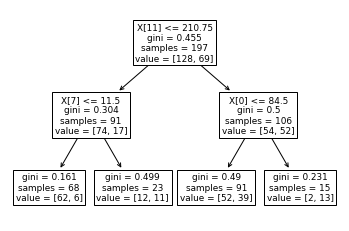

In [11]:
# Run model: do you use a testing set or just use it all because you know the accuracy??

# option 1: split into test and train
x_train, x_test, y_train, y_test = train_test_split(data_X, data_Y, test_size = .1)
print("Training Set Records:", len(x_train))
print("Testing Set Records:", len(x_test))


# option 2 = run it on all data
clf = DecisionTreeClassifier(criterion = "gini", 
                            max_depth = 2, 
                            max_features = 14, 
                            min_samples_leaf = 2)
print(tree.plot_tree(clf.fit(data_X, data_Y)))

In [24]:
# generate reports to get f1 score, and the rest of that stuff
from sklearn.metrics import classification_report
print(classification_report(data_Y, y_pred, labels = [0,1]))

NameError: name 'y_pred' is not defined